Here we'll compare the tuned GBC to the default parameter to see if that is the cause of the variation between XGBoost and GBC feature importance. 

The first cell below is simply importing the data/libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn import cross_validation, metrics   
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import operator 
import xgboost as xgb
from xgboost.sklearn import XGBClassifier 
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
trainData = pd.read_csv('1e7data_train.csv', index_col=0)
testData = pd.read_csv('1e7data_holdout.csv', index_col=0)
df = trainData
dftest = testData

feature_names = ['daOverRH1', 'daOverRH2', 'mindaOverRH', 'maxdaOverRH','norm_std_a1',
                 'norm_max_a1', 'norm_std_window10_a1', 'norm_max_window10_a1',
                'norm_std_a2', 'norm_std_window10_a2', 'norm_max_window10_a2', 'norm_max_a2',
                'norm_std_a3', 'norm_max_a3', 'norm_std_window10_a3', 'norm_max_window10_a3', 
                'avg_ecross1', 'std_ecross1', 'min_ecross1', 'max_ecross1', 
                'avg_ecross2', 'std_ecross2', 'max_ecross2', 'min_ecross2',
                'avg_ecross3', 'max_ecross3', 'min_ecross3', 'std_ecross3', 
                'norm_a1_slope', 'norm_a2_slope', 'norm_a3_slope', 'norm_LyapunovTime']

X_train = df[feature_names]


y_train = df['Stable']
X_test = dftest[feature_names]

X_train = X_train.replace(np.nan, -999)
X_train = X_train.replace(np.inf, -999)

X_test = X_test.replace(np.nan, -999)
X_test = X_test.replace(np.inf, -999)

model0 = XGBClassifier(colsample_bylevel=1, colsample_bytree=1,
                         n_estimators=5000, gamma=0,
                         max_delta_step=0, missing=None, 
                         reg_alpha=0, reg_lambda=1,
                         scale_pos_weight=1, seed=27,
                        learning_rate=.002, max_depth=8,
                        subsample=.5, min_child_weight=1.2, 
                        objective='binary:logistic', nthread=-1)

model0.fit(X_train, y_train)

/home/tom/anaconda2/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.002, max_delta_step=0, max_depth=8,
       min_child_weight=1.2, missing=None, n_estimators=5000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.5)

Now we train on the default parameters. 

In [2]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=5000)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

This sorts the features and scales the values.

In [3]:
vals = model.feature_importances_*100000

val_dict = dict(zip(feature_names, vals))
sorted_vals = sorted(val_dict.items(), key = operator.itemgetter(1))

feature_names_sorted = []
for scores in sorted_vals: 
    feature_names_sorted.append(scores[0])

vals_sorted = sorted(vals)


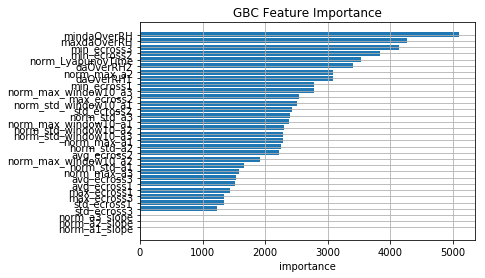

In [4]:
from pylab import *

points = vals_sorted

pos = arange(len(vals_sorted)) + .5 # centres the graph along y 

figure(1) # gives the figure a placeholder in memory
barh(pos, vals_sorted, align='center') 
yticks(pos, feature_names_sorted)
xlabel('importance')
title('GBC Feature Importance')
grid(True)
show()

Comparing above, and the next cell below, we see that it brings the model closer to what XGBoost calls important, but they still don't agree entirely.

The biggest discretion seems to be the norm_ax_slopes, which seem to be an error in GBC. 

The previous plot for GBC Feature Importance can be found below. 

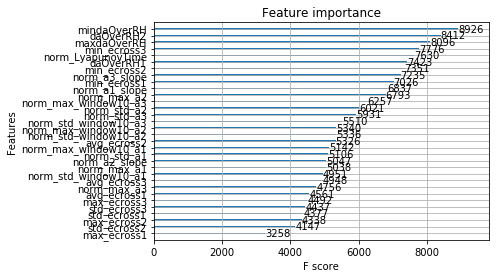

In [5]:
xgb.plot_importance(model0)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(loss='deviance', learning_rate=0.002, n_estimators=5000,
                                  subsample=.5,  min_samples_split=2, 
                                  min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=8,
                                  init=None, random_state=42, 
                                  max_leaf_nodes=8, warm_start=False, max_features=.5)

model.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.002, loss='deviance', max_depth=8,
              max_features=0.5, max_leaf_nodes=8, min_impurity_split=1e-07,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=5000,
              presort='auto', random_state=42, subsample=0.5, verbose=0,
              warm_start=False)

In [7]:
vals = model.feature_importances_*100000

val_dict = dict(zip(feature_names, vals))
sorted_vals = sorted(val_dict.items(), key = operator.itemgetter(1))

feature_names_sorted = []
for scores in sorted_vals: 
    feature_names_sorted.append(scores[0])

vals_sorted = sorted(vals)

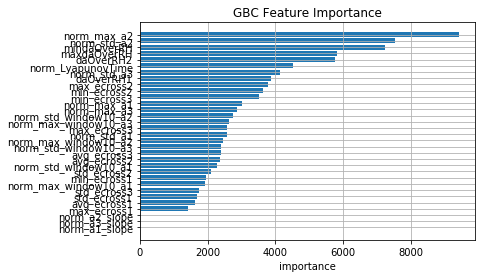

In [8]:
from pylab import *

points = vals_sorted

pos = arange(len(vals_sorted)) + .5 # centres the graph along y 

figure(1) # gives the figure a placeholder in memory
barh(pos, vals_sorted, align='center') 
yticks(pos, feature_names_sorted)
xlabel('importance')
title('GBC Feature Importance')
grid(True)
show()